In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools
import cv2 as cv

In [2]:
nod = np.load('nod.npy')
min, max = nod.min(), nod.max()
shape = nod.shape
# 容易知道，像素强度已经进行了归一化
print(f'min: {min}, max: {max}, shape: {shape}')

min: 0.09666666666666668, max: 1.0, shape: (64, 64, 16)


In [3]:
center = np.array(nod.shape) / 2

In [4]:
center = center.astype(np.int8)

In [5]:
center_x, center_y, center_z = tuple(center)

In [6]:
nod[center_x, center_y, center_z]

0.8386666666666666

In [39]:
nodule = nod.copy()
threshold = 0.7
nodule[nodule>threshold] = 1
nodule[nodule<=threshold] = 0

nodule = nodule.astype(np.uint8)
# inverse the pixel
# nodule[nodule==0] = 2
# nodule[nodule==1] = 0
# nodule[nodule==2] = 1

In [31]:
# test_slice = nodule[:, :, 8]
# kernel = np.ones((5, 5), np.uint)
# test_slice = cv.morphologyEx(test_slice.astype(np.uint8), cv.MORPH_OPEN, kernel)
# 每个方向对每层进行开运算

In [46]:
kernel = np.ones((3, 3), np.uint8)
# x
for x in range(nodule.shape[0]):
    nodule[x] = cv.morphologyEx(nodule[x], cv.MORPH_OPEN, kernel)
    
for y in range(nodule.shape[1]):
    nodule[:, x, :] = cv.morphologyEx(nodule[:, x, :], cv.MORPH_OPEN, kernel)

for z in range(nodule.shape[2]):
    nodule[:, :, z] = cv.morphologyEx(nodule[:, :, z], cv.MORPH_OPEN, kernel)
    
for x in range(nodule.shape[0]):
    nodule[x] = cv.morphologyEx(nodule[x], cv.MORPH_CLOSE, kernel)
    
for y in range(nodule.shape[1]):
    nodule[:, x, :] = cv.morphologyEx(nodule[:, x, :], cv.MORPH_CLOSE, kernel)

for z in range(nodule.shape[2]):
    nodule[:, :, z] = cv.morphologyEx(nodule[:, :, z], cv.MORPH_CLOSE, kernel)

In [47]:
tools.npy2nii(nodule, 'nod.nii')

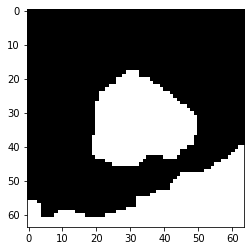

In [48]:
plt.imshow(nodule[:, :, 8], 'gray')

In [49]:
import skimage.measure as measure

array([[18, 29],
       [18, 30],
       [18, 31],
       ...,
       [45, 30],
       [45, 31],
       [45, 32]])

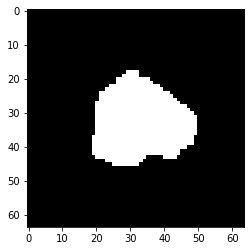

In [74]:
test_slice = nodule[:, :, 8]
label = measure.label(test_slice, connectivity=1)
# 找到生长点的类型
center_type = label[32, 32]

# 将生长点的连通域设置为1
label[label!=center_type] = 0
label[label==center_type] = 1
plt.imshow(label, 'gray')
np.argwhere(label == 1)

In [77]:
# 求3D连通域
init_slice = nodule[center_x]
# 假定初始中心点为结节像素点
p1, p2 = center_y, center_z
# 中心层到0层
for index_x in range(center_x, -1, -1):
    label = measure.label(test_slice, connectivity=1)
    center_type = nodule[index_x, p1, p2]
    label[label==center_type] = 1
    label[label!=center_type] = 0
    # 寻找下一层的生长点(必须是结节像素点), 遍历此层相同坐标的点
    for p in np.argwhere(label == 1):
        if nodule[index_x - 1, p[0], p[1]] == 1:
            p1, p2 = p[0], p[1]
            break
    print(index_x, center_x)
    
# 中心层到最后一层
# for index_x in range(center_x, shape[0]):
#     print(center_x, index_x)

IndexError: index 29 is out of bounds for axis 2 with size 16

## 解决方案

1. 对图像进行二值化（目前是手动填写阈值，可以事先统计一下两个峰值，以此确定阈值）
2. 各个方向对每层图像进行开运算，防止结节泄露与外界连通（似乎是人为创造了边界，这里可以考虑进行梯度计算，计算出边缘）
3. 各个方向对图像进行闭运算，去除被结节包裹的低强度像素（被误判为正常的像素点）
3. 找到中心点最近的高强度像素点（防止中心点没有被闭运算消除），并寻找这个点的连通域
4. 计算指标：体积、长轴、短轴、表面体积比

注意：分别对各个方向进行开闭运算来代替3D开闭运算是有缺陷的